In [1]:
# Imports
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import glob
import torch.nn as nn
import torchvision

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
from torchvision.datasets import Cityscapes
import torch.nn as nn
import torch.nn.functional as F

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
torch.backends.cudnn.benchmark = False

torch.cuda.empty_cache()

import warnings
warnings.filterwarnings('ignore')

In [3]:
#!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=s8awdesh&password=OfficialNLP*&submit=Login' https://www.cityscapes-dataset.com/login/

#!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3 # => leftImg8bit
#!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1 #=> gtFine

#!unzip gtFine_trainvaltest.zip
#!unzip leftImg8bit_trainvaltest.zip

In [4]:
def recursive_glob(rootdir=".", suffix=""):
    """Performs recursive glob with given suffix and rootdir
    :param rootdir is the root directory
    :param suffix is the suffix to be searched
    """
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]

class cityscapesLoader(data.Dataset):
    """
    cityscapesLoader
    https://www.cityscapes-dataset.com
    Data is derived from CityScapes, and can be downloaded from here:
    https://www.cityscapes-dataset.com/downloads/
    Many Thanks to @fvisin for the loader repo:
    https://github.com/fvisin/dataset_loaders/blob/master/dataset_loaders/images/cityscapes.py
    """
    
    colors = [
        #[0,   0,   0], 
        [128, 64, 128], [244, 35, 232], [70, 70, 70],
        [102, 102, 156], [190, 153, 153], [153, 153, 153], [250, 170, 30],
        [220, 220, 0], [107, 142, 35], [152, 251, 152], [0, 130, 180],
        [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
        [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32],
    ]
    
    label_colours = dict(zip(range(19), colors))
    mean_rgb = {
        "pascal": [103.939, 116.779, 123.68],
        "cityscapes": [0.0, 0.0, 0.0],
    }  # pascal mean for PSPNet and ICNet pre-trained model
    
    def __init__(
        self,
        root,
        split="train",
        is_transform=False,
        img_size=(512, 1024),
        augmentations=None,
        img_norm=True,
        version="cityscapes",
        test_mode=False,
    ):
        """__init__
        :param root:
        :param split:
        :param is_transform:
        :param img_size:
        :param augmentations
        """
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array(self.mean_rgb[version])
        self.files = {}
        
        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")
        
        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25,
                              26, 27, 28, 31, 32, 33,]
        
        self.class_names = [#"unlabelled", 
                            "road", "sidewalk", "building",
                            "wall", "fence", "pole", "traffic_light",
                            "traffic_sign", "vegetation", "terrain", "sky",
                            "person", "rider", "car", "truck", "bus",
                            "train", "motorcycle", "bicycle"
                           ]
        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_classes, range(0,19)))
        
        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))
        
        print("Found %d %s images" % (len(self.files[split]), split))
    
    def __len__(self):
        return len(self.files[self.split])+0
    
    def __getitem__(self, index):
        """__getitem__
        :param index:
        """
        img_path = self.files[self.split][index].rstrip()
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )
        
        img = m.imread(img_path)
        img = np.array(img, dtype=np.uint8)
        
        lbl = m.imread(lbl_path)
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))
        
        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)
        
        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        
        return img, lbl
    
    def transform(self, img, lbl):
        """transform
        :param img:
        :param lbl:
        """
        img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)
        
        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
        lbl = lbl.astype(int)
        
        if not np.all(classes == np.unique(lbl)):
            print("WARN: resizing labels yielded fewer classes")
        
        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")
        
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        
        return img, lbl
    
    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]
        
        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        
        return rgb

    def encode_segmap(self, mask):
        # Put all void classes to zero
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

In [5]:
# Model Architecture Unet3Plus

In [6]:
class conv2(nn.Module):
    def __init__(self, in_c, out_c, t=2, kernel=3, stride=1, padding=1):
        super(conv2, self).__init__()
        self.t = t
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        
        for i in range(1, t+1):
            conv = nn.Sequential(nn.Conv2d(in_c, out_c, kernel, stride, padding),
                                 nn.BatchNorm2d(out_c), 
                                 nn.ReLU(inplace=True)
                                )
            setattr(self, 'conv%d' % i, conv)
            in_c = out_c
    
    def forward(self, image):
        x = image
        for i in range(1, self.t + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)
        return x
    
class UNet3Plus(nn.Module):
    def __init__(self, n_classes=1, bilinear=True, feature_scale=4,
                 is_deconv=True):
        super(UNet3Plus, self).__init__()
        
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.feature_scale = feature_scale
        self.is_deconv = is_deconv
        filters = [64, 128, 256, 512, 1024]
        
        ## -------------Encoder--------------
        self.conv1 = conv2(3, filters[0])
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = conv2(filters[0], filters[1])
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = conv2(filters[1], filters[2])
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = conv2(filters[2], filters[3])
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = conv2(filters[3], filters[4])
        
        ## -------------Decoder--------------
        self.cat_channels = filters[0]
        self.cat_blocks = 5
        self.up_channels = self.cat_channels * self.cat_blocks
        
        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.cat_channels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.cat_channels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)
        
        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.cat_channels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.cat_channels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)
        
        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.cat_channels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.cat_channels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)
        
        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.cat_channels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.cat_channels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.cat_channels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)
        
        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.up_channels, self.up_channels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.up_channels)
        self.relu4d_1 = nn.ReLU(inplace=True)
        
        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.cat_channels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.cat_channels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.cat_channels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.cat_channels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.cat_channels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.cat_channels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.up_channels, self.cat_channels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.cat_channels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)
        
         # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.up_channels, self.up_channels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.up_channels)
        self.relu3d_1 = nn.ReLU(inplace=True)
        
        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.cat_channels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.cat_channels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.cat_channels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.cat_channels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.up_channels, self.cat_channels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.up_channels, self.cat_channels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.cat_channels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)
        
        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.up_channels, self.up_channels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.up_channels)
        self.relu2d_1 = nn.ReLU(inplace=True)
        
        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.cat_channels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.cat_channels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.up_channels, self.cat_channels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.up_channels, self.cat_channels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.up_channels, self.cat_channels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.cat_channels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.cat_channels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.up_channels, self.up_channels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.up_channels)
        self.relu1d_1 = nn.ReLU(inplace=True)
        
        # output
        self.out = nn.Conv2d(self.up_channels, 34, 3, padding=1)
        
    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d1 = self.out(hd1)  # d1->320*320*n_classes
        #return F.sigmoid(d1)
        return d1

In [7]:
local_path = "./"
epochs = 5
bs = 2

In [8]:
# dataset variable
# augs = aug.Compose([aug.RandomRotate(10), aug.RandomHorizontallyFlip()])


traindataset = torchvision.datasets.Cityscapes(root=local_path, split='train', mode='fine',
                                               target_type='semantic', transform=transforms.Compose([transforms.Resize((256,512)),transforms.ToTensor()]), 
                                               target_transform=transforms.Compose([transforms.Resize((256,512)),transforms.ToTensor()]))
validdataset = torchvision.datasets.Cityscapes(root=local_path, split='val', mode='fine',
                                               target_type='semantic', transform=transforms.Compose([transforms.Resize((256,512)),transforms.ToTensor()]), 
                                               target_transform=transforms.Compose([transforms.Resize((256,512)),transforms.ToTensor()]))

# traindataset = cityscapesLoader(root=local_path, is_transform=True, split='train')
# validdataset = cityscapesLoader(root=local_path, is_transform=True, split='val')

# dataloader variable
trainloader = data.DataLoader(traindataset, batch_size=bs, shuffle=True)
validloader = data.DataLoader(validdataset, batch_size=bs, shuffle=False)

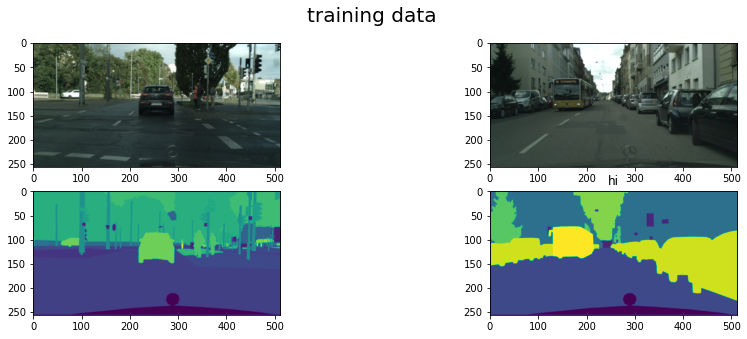

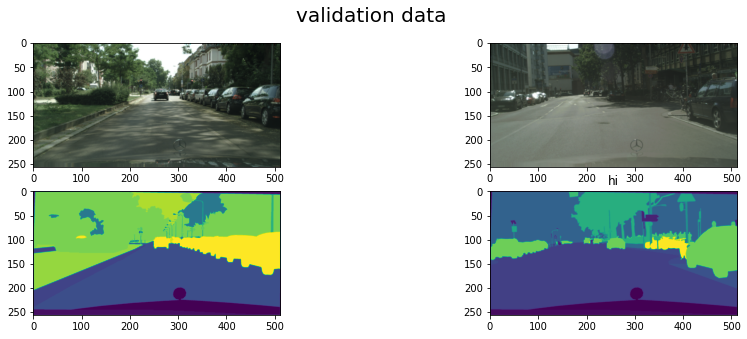

In [9]:
# Batch-wise visualisation

# i, d in enumerate(trainloader) ---> here, d is list
# img--d[0] has the shape [2,3,512,512] or [batch_sz, #img_channels, img_sz, img_sz] -- img batch
# label--d[1] has the shape [2, 512, 512] or [batch_sz, mask_sz, mask_sz] -- mask batch
# Verifying training and validation data
def visualize_data(batch_sz, loader, dataset_var, data_title):
    dst = dataset_var
    for i, data in enumerate(loader):
        # increase the count if u want to visualize more batches
        if i>0:
            break
        imgs, labels = data
        imgs = imgs.numpy()
        imgs = np.transpose(imgs, [0,2,3,1])
        labels = labels.squeeze(1)

        fig, axes = plt.subplots(nrows = 2, ncols = batch_sz, figsize=(15,5))
        fig.suptitle(data_title, fontsize=20)
        for j in range(0, batch_sz):
            I = imgs[j]
            axes[0,j].imshow(np.clip(I, 0, 1))
            axes[1,j].imshow(labels.numpy()[j])
        plt.title('hi')
        plt.show()

visualize_data(bs, trainloader, traindataset, 'training data')
visualize_data(bs, validloader, validdataset, 'validation data')

In [10]:
model = UNet3Plus()

In [11]:
# loss function
loss_f = nn.CrossEntropyLoss()

# optimizer variable
# opt = torch.optim.SGD(model.parameters(), weight_decay=5*1e-4, lr = 0.0001, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
def save_checkpoint(state, filename="task3_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])

In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate(dataset, data_loader, model, epoch):
    # put model in eval mode
    model.eval()
    # init final_loss to 0
    final_loss = 0
    # calculate number of batches and init tqdm
    num_batches = int(len(dataset) / data_loader.batch_size)
    tk0 = tqdm(data_loader, total=num_batches)
    # we need no_grad context of torch. this save memory
    with torch.no_grad():
        for inputs, targets in tk0:
            tk0.set_description(f"Validation Epoch {epoch+1}")
            inputs = inputs.to(DEVICE, dtype=torch.float)
            targets = targets.to(DEVICE, dtype=torch.long)
            targets = targets.squeeze(1)
            output = model(inputs)
            loss = criterion(output, targets)
            # add loss to final loss
            final_loss += loss
            tk0.set_postfix(loss = (final_loss / num_batches).item())
    # close tqdm
    tk0.close()
    # return average loss over all batches
    return final_loss / num_batches

def train(traindataset, validdataset, trainloader, validloader, model, criterion, optimizer, epochs, Load_Model=False):
    """
    training function that trains for one epoch
    :param dataset: dataset class (SIIMDataset)
    :param data_loader: torch dataset loader
    :param model: model
    :param criterion: loss function
    :param optimizer: adam, sgd, etc.
    """
    
    if torch.cuda.is_available():
        criterion = criterion.cuda()
    
    train_loss = []
    valid_loss = []
    model_weights = []
    valid_loss_min = np.Inf
    
    if Load_Model:
        load_checkpoint("task3_checkpoint.pth.tar", model)
    
    for epoch in range (epochs):
        model.train()
        
        with tqdm(trainloader, unit="batch") as tk0:
            for inputs, targets in tk0:
                tk0.set_description(f"Epoch {epoch+1}")
                # zero grad the optimizer
                optimizer.zero_grad()
                
                # fetch input images and masks from dataset batch
                # move images and masks to cpu/gpu device
                inputs = inputs.to(DEVICE, dtype=torch.float)
                targets = targets.to(DEVICE, dtype=torch.long)
                targets = targets.squeeze(1)
                
                # forward step of model
                outputs = model(inputs)
                # calculate loss
                loss = criterion(outputs,targets)
                loss.backward()
                # step the optimizer
                optimizer.step()
                tk0.set_postfix(loss=loss.item())
        val_loss_log = evaluate(validdataset, validloader, model, epoch)

        
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        
        if val_loss_log <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min,val_loss_log))
            # save checkpoint as best model
            save_checkpoint(checkpoint)
            valid_loss_min = val_loss_log
        
        train_loss.append(loss.item())
        valid_loss.append(val_loss_log.item())
        
    return train_loss, valid_loss, model_weights

In [14]:
model.to(DEVICE)

UNet3Plus(
  (conv1): conv2(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): conv2(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [15]:
criterion = loss_f
history = train(traindataset, validdataset, trainloader, validloader, model, criterion, opt, epochs)

Validation Epoch 1: 100%|██████████| 250/250 [01:15<00:00,  3.30it/s, loss=0.000151]


Validation loss decreased (inf --> 0.000151). Saving model ...
=> Saving checkpoint


Validation Epoch 2: 100%|██████████| 250/250 [01:21<00:00,  3.09it/s, loss=3.89e-5]


Validation loss decreased (0.000151 --> 0.000039). Saving model ...
=> Saving checkpoint


Validation Epoch 3: 100%|██████████| 250/250 [01:22<00:00,  3.05it/s, loss=1.47e-5]


Validation loss decreased (0.000039 --> 0.000015). Saving model ...
=> Saving checkpoint


Validation Epoch 4: 100%|██████████| 250/250 [01:14<00:00,  3.34it/s, loss=6.19e-6]


Validation loss decreased (0.000015 --> 0.000006). Saving model ...
=> Saving checkpoint


Validation Epoch 5: 100%|██████████| 250/250 [01:13<00:00,  3.40it/s, loss=3.22e-6]


Validation loss decreased (0.000006 --> 0.000003). Saving model ...
=> Saving checkpoint


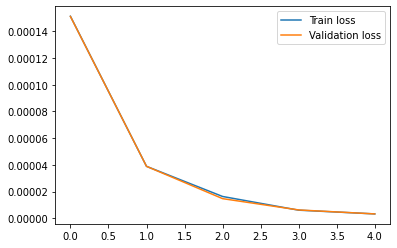

In [16]:
plt.plot(history[0])
plt.plot(history[1])
plt.legend(['Train loss', 'Validation loss'])
plt.show()

In [18]:
# Source: https://github.com/kevinzakka/pytorch-goodies/blob/master/metrics.py

EPS = 1e-10
def nanmean(x):
    """Computes the arithmetic mean ignoring any NaNs."""
    return torch.mean(x[x == x])

def _fast_hist(true, pred, num_classes):
    mask = (true >= 1) & (true < num_classes)
    hist = torch.bincount(
        num_classes * true[mask] + pred[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist

def overall_pixel_accuracy(hist):
    """Computes the total pixel accuracy.
    The overall pixel accuracy provides an intuitive
    approximation for the qualitative perception of the
    label when it is viewed in its overall shape but not
    its details.
    Args:
        hist: confusion matrix.
    Returns:
        overall_acc: the overall pixel accuracy.
    """
    correct = torch.diag(hist).sum()
    total = hist.sum()
    overall_acc = correct / (total + EPS)
    return overall_acc

def per_class_pixel_accuracy(hist):
    """Computes the average per-class pixel accuracy.
    The per-class pixel accuracy is a more fine-grained
    version of the overall pixel accuracy. A model could
    score a relatively high overall pixel accuracy by
    correctly predicting the dominant labels or areas
    in the image whilst incorrectly predicting the
    possibly more important/rare labels. Such a model
    will score a low per-class pixel accuracy.
    Args:
        hist: confusion matrix.
    Returns:
        avg_per_class_acc: the average per-class pixel accuracy.
    """
    correct_per_class = torch.diag(hist)
    total_per_class = hist.sum(dim=1)
    per_class_acc = correct_per_class / (total_per_class + EPS)
    avg_per_class_acc = nanmean(per_class_acc)
    return avg_per_class_acc


def jaccard_index(hist):
    """Computes the Jaccard index, a.k.a the Intersection over Union (IoU).
    Args:
        hist: confusion matrix.
    Returns:
        avg_jacc: the average per-class jaccard index.
    """
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    jaccard = A_inter_B / (A + B - A_inter_B + EPS)
    avg_jacc = nanmean(jaccard)
    return avg_jacc

def dice_coefficient(hist):
    """Computes the Sørensen–Dice coefficient, a.k.a the F1 score.
    Args:
        hist: confusion matrix.
    Returns:
        avg_dice: the average per-class dice coefficient.
    """
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    dice = (2 * A_inter_B) / (A + B + EPS)
    avg_dice = nanmean(dice)
    return avg_dice

def eval_metrics(true, pred, num_classes):
    """Computes various segmentation metrics on 2D feature maps.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        pred: a tensor of shape [B, H, W] or [B, 1, H, W].
        num_classes: the number of classes to segment. This number
            should be less than the ID of the ignored class.
    Returns:
        overall_acc: the overall pixel accuracy.
        avg_per_class_acc: the average per-class pixel accuracy.
        avg_jacc: the jaccard index.
        avg_dice: the dice coefficient.
    """
    hist = torch.zeros((num_classes, num_classes))
    for t, p in zip(true, pred):
        hist += _fast_hist(t.flatten(), p.flatten(), num_classes)
    overall_acc = overall_pixel_accuracy(hist)
    avg_per_class_acc = per_class_pixel_accuracy(hist)
    avg_jacc = jaccard_index(hist)
    avg_dice = dice_coefficient(hist)
    return overall_acc, avg_per_class_acc, avg_jacc, avg_dice

load_checkpoint("task3_checkpoint.pth.tar", model)
model.eval()

overall_acc_final = 0
avg_per_class_acc_final = 0
avg_jacc_final = 0
avg_dice_final = 0

num_batches = int(len(traindataset)/bs) # len(traindataset) is the total train images and bs is the batch_size 

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)            

        output = torch.sigmoid(model(images))
        output_2d = torch.argmax(output, dim=1).detach().cpu()
        labels = labels.cpu()
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = eval_metrics(labels, output_2d, 20)
        overall_acc_final += overall_acc.numpy()
        avg_per_class_acc_final += avg_per_class_acc.numpy()
        avg_jacc_final += avg_jacc.numpy()
        avg_dice_final += avg_dice.numpy()

print(f'overall_acc: {overall_acc_final/num_batches}, avg_per_class_acc: {avg_per_class_acc_final/num_batches},\
avg_jacc or iou: {avg_jacc_final/num_batches}, avg_dice: {avg_dice_final/num_batches}')

=> Loading checkpoint


RuntimeError: "bincount_cpu" not implemented for 'Float'

In [ ]:
def multi_chnl_to_2d(output):    

    pr_mask_2d = np.zeros((output.shape[0], output.shape[1]))
    for chnl in range(0, output.shape[2]):
        pr_mask_2d[output[:,:,chnl] == 1] = chnl
        
    return pr_mask_2d

In [ ]:
load_checkpoint("task3_checkpoint.pth.tar", model)
model.eval()
for batch_idx, (images,labels) in enumerate(trainloader):
    # Number of batches to analyze
    if batch_idx>0:
        break
    #output = model(images.cuda())
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    output = torch.sigmoid(model(images))
    output = (output.cpu().detach().numpy().transpose([0,2,3,1]) > 0.5)*1
    
    imgs = images.cpu().numpy().transpose([0,2,3,1])
    
    # Analyzing every image in the batch
    for img_num in range(0,bs): 
        plt.figure(figsize=(15,20))
        plt.subplot(1,3,1).set_title('Original_Image')
        plt.imshow(np.clip(imgs[img_num,:,:,:], 0, 1))
        plt.subplot(1,3,2).set_title('Ground Truth')
        plt.imshow(traindataset.decode_segmap(labels.cpu().numpy()[img_num])) # Single channel GT mask to RGB Image
        plt.subplot(1,3,3).set_title('Prediction_UNet')
        plt.imshow(traindataset.decode_segmap(multi_chnl_to_2d(output[img_num,:,:,:]))) # Single channel prediction mask to RGB Image
        #plt.savefig('./saved_results_task1/all_res_batch_' + str(batch_idx) + '_img_' + str(img_num) + '.png')  

In [ ]:
#load_checkpoint("./trained_models/m3_best_model_my_checkpoint_20ep_smpUnet.pth.tar", model)
load_checkpoint("task3_checkpoint.pth.tar", model)

model.eval()

for batch_idx, (images,labels) in enumerate(trainloader):
    # Number of batches to analyze
    if batch_idx>0:
        break
    #output = model(images.cuda())
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    output = torch.sigmoid(model(images))
    output_2d = torch.argmax(output, dim=1).detach().cpu().numpy()
    
    imgs = images.cpu().numpy().transpose([0,2,3,1])
    
    # Analyzing every image in the batch
    for img_num in range(0,bs): 
        plt.figure(figsize=(15,20))
        plt.subplot(1,3,1).set_title('Original_Image')
        plt.imshow(np.clip(imgs[img_num,:,:,:], 0, 1))
        plt.subplot(1,3,2).set_title('Ground Truth')
        plt.imshow(traindataset.decode_segmap(labels.cpu().numpy()[img_num])) # Single channel GT mask to RGB Image
        plt.subplot(1,3,3).set_title('Prediction_UNet')
        plt.imshow(traindataset.decode_segmap(output_2d[img_num])) # Single channel prediction mask to RGB Image
        #plt.savefig('./saved_results_task1/all_res_batch_' + str(batch_idx) + '_img_' + str(img_num) + '.png')  

### References: 

https://github.com/avBuffer/UNet3plus_pth/blob/master/unet/UNet3Plus.py <br/>
https://github.com/ZJUGiveLab/UNet-Version/blob/master/models/UNet_3Plus.py